# 锚框
- 对锚框算法的整个流程进行编写代码并查看具体的效果

In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

(3, 561, 728)

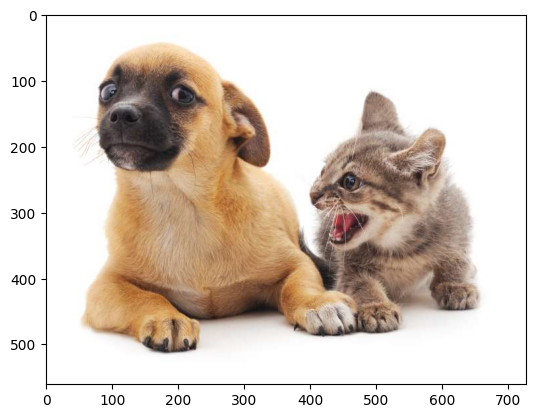

In [2]:
a = Image.open("catdog.jpg")
plt.imshow(a)
b = np.array(a)
img = b.reshape(-1, b.shape[0], b.shape[1])
img.shape

In [3]:
b.shape

(561, 728, 3)

## 1 每个像素生成多个锚框

In [4]:
def multibox_prior(data, scale, ratio):
    """
    data为输入的数据,每个位置生成锚框,通道数没有用到.
    input:
        data: 输入图像，形状后两维应是图像高和宽
        scale:是缩放比，是得出的锚框面积占原图像的多少
        ratio:宽高比，生成的锚框的宽高比
    output:
        返回锚框，（批量大小，锚框数量，每个锚框坐标（四个值））,是左上角坐标和右下角坐标.
    """
    in_height, in_width = data.shape[-2], data.shape[-1]
    device, num_scale, num_ratio = data.device, len(scale), len(ratio)
    boxes_per_pixel = (num_scale + num_ratio - 1)
    scale_tensor = torch.tensor(scale, device = device)
    ratio_tensor = torch.tensor(ratio, device = device)
    
    #生成所有锚框中心点，因为像素的长宽都是1，所以步长要为0.5
    offset_h, offset_w = 0.5, 0.5
    center_x_all = torch.arange(in_height, device = device) + offset_h
    center_y_all = torch.arange(in_width, device = device) + offset_w
    center_x, center_y = torch.meshgrid(center_x_all, center_y_all, indexing = 'ij')
    center_x, center_y = center_x.reshape(-1), center_y.reshape(-1)  #转为一维向量，对应xy构成中心点坐标。
    
    #生成每个锚框的宽和高，是由缩放比和宽高比计算得到的。
    #w和h是先scale乘ratio第一个元素，再计算scale第一个元素乘ratio除了第一个元素的其他元素。用torch.cat来合到一维上。
    wh = torch.sqrt(torch.tensor(in_height) * torch.tensor(in_width))
    w = torch.cat((torch.sqrt(scale_tensor * ratio_tensor[0]), torch.sqrt(scale_tensor[0] * ratio_tensor[1:]))) * wh
    h = torch.cat((torch.sqrt(scale_tensor / ratio_tensor[0]), torch.sqrt(scale_tensor[0] / ratio_tensor[1:]))) * wh
    
    #宽高除以2来得到宽高的一半，以便通过中心点快速找到每个锚框右上角和右下加.
    #每个像素有boxes_per_pixel边框，故重复in_height * in_width像素次数。
    anchor_manipulations = torch.stack((-w, -h, w, h), dim = 1).repeat(in_height * in_width, 1) / 2
    """操作实例就是这样
    a = torch.tensor([0, 1])
    b = torch.tensor([2, 3])
    torch.stack((a,b)).T, torch.stack((a,b)).T.repeat(2, 1), torch.stack((a,b)).T.repeat_interleave(2, dim = 0)
    torch.stack((a,b)).T.repeat(2, 1) + torch.stack((a,b)).T.repeat_interleave(2, dim = 0)
    """
    
    #每个中心点有boxes_per_pixel锚框
    #有in_height * in_width个像素，每个像素有boxes_per_pixel边框。
    out_grid = torch.stack((center_x, center_y, center_x, center_y), dim = 1).repeat_interleave(boxes_per_pixel, dim=0)
    #得到每个像素的boxes_per_pixel个锚框
    output = out_grid + anchor_manipulations
    
    return output.unsqueeze(0)  #unsqueeze(i),在第i维上增加一个维度。squeeze()是移除维度大小为1的维度。

In [5]:
h, w = img.shape[-2:]
print(h, w)
X = torch.rand(size=(2, 3, h, w))
Y = multibox_prior(X, scale=[0.75, 0.5, 0.25], ratio=[1, 2, 0.5])
Y.shape, X.shape

561 728


(torch.Size([1, 2042040, 4]), torch.Size([2, 3, 561, 728]))

In [6]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, :2, :], boxes[300, 300, :2, :]

(tensor([[-26.2246, -26.2246, 527.2246, 527.2246],
         [ 24.5553,  24.5553, 476.4447, 476.4447]]),
 tensor([[ 23.7754,  23.7754, 577.2246, 577.2246],
         [ 74.5553,  74.5553, 526.4447, 526.4447]]))

### 显示边框

In [7]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = plt.Rectangle(xy = (bbox[0], bbox[1]), width = bbox[2]-bbox[0], height = bbox[3]-bbox[1], 
                             fill = False, edgecolor = color, linewidth = 2)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

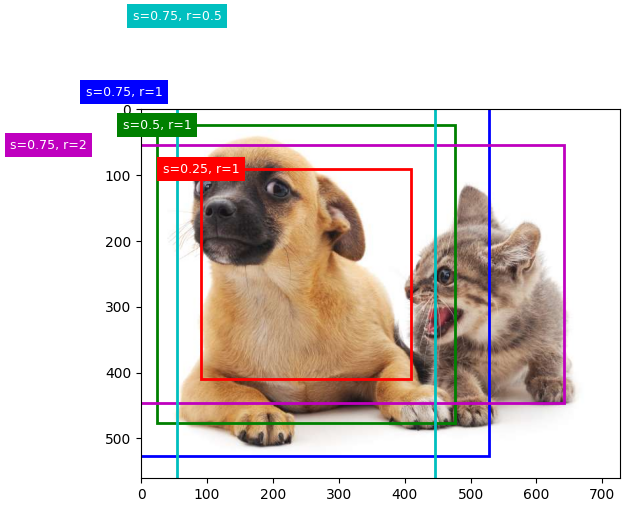

In [8]:
fig = plt.imshow(a)
show_bboxes(fig.axes, boxes[250, 250, :, :],
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

## 2 交并比

In [23]:
def box_iou(boxes1, boxes2):
    """
    input:
        boxes1:输入的第一个批量锚框(n, m)n是有多少个锚框,m是锚框的左上角和左下角的四个值先x后y.
        boxes2:输入的第二个批量锚框(n, m)n是有多少个锚框,m是锚框的左上角和左下角的四个值先x后y.
    output:
        返回n个锚框的交并比.
    """
    def box_area(boxes):
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        return area
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    
    #注意:是boxes1与boxes2中的每个锚框都要计算交并比,并不是只计算对应行的锚框的交并比.这个要进行注意
    #找输入锚框boxes1和boxes2的左上角的最大的坐标,计算交并比.用了广播机制.
    inter_upperleft = torch.max(boxes1[:, :2].unsqueeze(dim = 1), boxes2[:, :2])
    #找输入锚框boxes1和boxes2的右下角的最小坐标.用了广播机制.
    inter_lowerright = torch.min(boxes1[:, 2:].unsqueeze(dim = 1), boxes2[:, 2:])
    #clamp(min = 0)是因为有些锚框是没有相交的,这样算的值都是负的.
    inter = (inter_lowerright - inter_upperleft).clamp(min = 0)
    
    #相交区域
    inter_area = inter[:, :, 0] * inter[:, :, 1]
    #相并区域,union_area行是boxes1的锚框,列是boxes1中每个锚框与boxes2中每个锚框相并区域,用了广播机制.
    union_area = area1.unsqueeze(dim = 1) + area2 - inter_area
    
    return inter_area / union_area

In [10]:
boxes1 = boxes[250, 250, :2, :] 
boxes2 = boxes[300, 300, :2, :]
print(boxes1, boxes2)
box_area(boxes1, boxes2)

tensor([[-26.2246, -26.2246, 527.2246, 527.2246],
        [ 24.5553,  24.5553, 476.4447, 476.4447]]) tensor([[ 23.7754,  23.7754, 577.2246, 577.2246],
        [ 74.5553,  74.5553, 526.4447, 526.4447]])


tensor([[0.7057, 0.6667],
        [0.6667, 0.6542]])

## 3 将真是边界框分配给锚框

In [11]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    #构建一个全为-1的一个矩阵，为将真实边界框分配给锚框做准备
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    #找到真实边界框与锚框在列维度上的IoU的最大值(因为列是真实边界框),返回的是在列维度上的IoU最大值,最大值的索引.
    max_ious, indices = torch.max(jaccard, dim=1)
    #计算max_ious张量中大于或等于iou_threshold阈值的元素的索引，并将这些索引存储在一维张量anc_i中。
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [12]:
a = torch.tensor([0, 1, 2])
b = torch.tensor([0.5, 0.6, 0.4])
a[b >= 0.5]

tensor([0, 1])

### 偏移量转换

In [13]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    def box_corner_to_center(boxes):
        x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        w = x2 - x1
        h = y2 - y1
        boxes = torch.stack((cx, cy, w, h), dim = -1)
        return boxes
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

### 使用真实边界框标注锚框的类别和偏移量

In [14]:
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

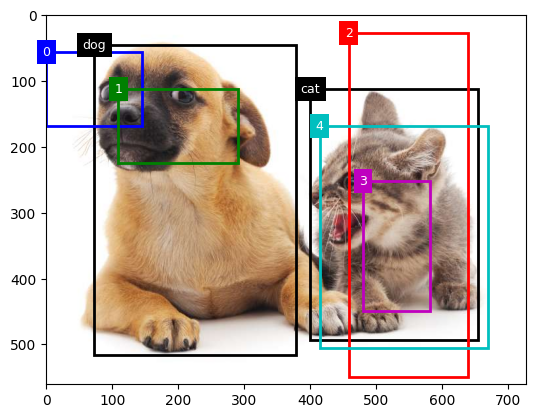

In [15]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])
bbox_scale = torch.tensor((w, h, w, h))
a = Image.open("catdog.jpg")
fig = plt.imshow(a)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

## 2 使用非极大值抑制预测边界框

In [16]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    def box_corner_to_center(boxes):
        x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        w = x2 - x1
        h = y2 - y1
        boxes = torch.stack((cx, cy, w, h), dim = -1)
        return boxes
    def box_center_to_corner(boxes):
        cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
        x1 = cx - (w / 2)
        y1 = cy - (h / 2)
        x2 = cx + (w / 2)
        y2 = cy + (h / 2)
        boxes = torch.stack((x1, y1, x2, y2), axis=-1)
        return boxes
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

### 对预测的边界框的置信度进行排序

In [17]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_area(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

### 使用非极大值抑制来预测边界框

In [18]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [19]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

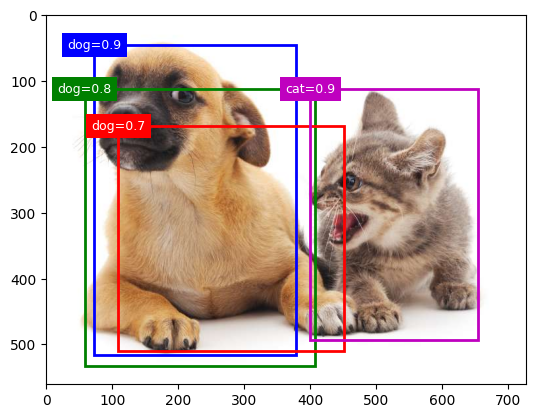

In [20]:
a = Image.open("catdog.jpg")
fig = plt.imshow(a)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [21]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100]]])

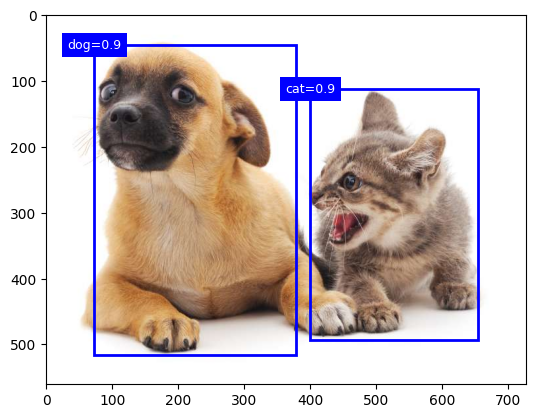

In [22]:
fig = plt.imshow(a)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)